In [1]:
from requests import get
import requests
from bs4 import BeautifulSoup
import re
import time
import polars as pl
from sklearn.model_selection import train_test_split
import seaborn as sns
import joblib
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
def get_lol_champions():
    #1 Récupération du dernier numéro de patch
    try:
        version_url = "https://ddragon.leagueoflegends.com/api/versions.json"
        latest_version = requests.get(version_url).json()[0]
        print(f"Chargement des données pour le patch : {latest_version}")
    except Exception as e:
        print(f"Erreur lors de la récupération de la version : {e}")
        return

    #2. Télécharger les données avec l'URL dynamique
    url = f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/champion.json"
    
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erreur lors du téléchargement des champions (Status: {response.status_code})")
        return

    data = response.json()
    champions_dict = data['data']

    #3. On chope les infos (Ta logique existante)
    rows = []
    for champ_name, details in champions_dict.items():
        stats = details['stats']
        info = details['info']
        
        rows.append({
            "Name": champ_name,
            "Class": details['tags'][0],  # Rôle principal
            "AttackRange": stats['attackrange'],
            "MoveSpeed": stats['movespeed'],

            "HP": stats['hp'],
            "HPperLevel": stats['hpperlevel'],

            "hpregen": stats['hpregen'],
            "hpregenperlevel": stats['hpregenperlevel'],

            "Armor": stats['armor'],
            "ArmorperLevel": stats['armorperlevel'],
            
            "AttackDamage": stats['attackdamage'],
            "AttackDamageperLevel": stats['attackdamageperlevel'],

            "attackspeed": stats['attackspeed'],
            "attackspeedperlevel": stats['attackspeedperlevel'],

            "Spellblock": stats['spellblock'],
            "spellblockperlevel": stats['spellblockperlevel'],

            "Prv_attack": info['attack'],
            "Prv_defense": info['defense'],
            "Prv_magic": info['magic']
        })

    #4. Créer le Tableau + Polars
    tableau_champ = pl.DataFrame(rows)
    
    

    # Affichage 
    pl.Config.set_tbl_rows(10) 
    print(tableau_champ)
    #suuuuuper important pour la suite sinon c'est ko
    return tableau_champ

if __name__ == "__main__":
    tableau_champ = get_lol_champions()

Chargement des données pour le patch : 16.1.1
shape: (172, 19)
┌─────────┬──────────┬────────────┬───────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Name    ┆ Class    ┆ AttackRang ┆ MoveSpeed ┆ … ┆ spellblock ┆ Prv_attac ┆ Prv_defen ┆ Prv_magic │
│ ---     ┆ ---      ┆ e          ┆ ---       ┆   ┆ perlevel   ┆ k         ┆ se        ┆ ---       │
│ str     ┆ str      ┆ ---        ┆ i64       ┆   ┆ ---        ┆ ---       ┆ ---       ┆ i64       │
│         ┆          ┆ i64        ┆           ┆   ┆ f64        ┆ i64       ┆ i64       ┆           │
╞═════════╪══════════╪════════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ Aatrox  ┆ Fighter  ┆ 175        ┆ 345       ┆ … ┆ 2.05       ┆ 8         ┆ 4         ┆ 3         │
│ Ahri    ┆ Mage     ┆ 550        ┆ 330       ┆ … ┆ 1.3        ┆ 3         ┆ 4         ┆ 8         │
│ Akali   ┆ Assassin ┆ 125        ┆ 345       ┆ … ┆ 2.05       ┆ 5         ┆ 3         ┆ 8         │
│ Akshan  ┆ Marksman ┆ 500  

In [5]:
#Séparation
#1. On chope la liste des colonnes statistiques (les "Features")
# On vire "Name", "Class" et "Target"
features_cols = [
    col for col in tableau_champ.columns 
    if col not in ["Name", "Class", "Target"]
]

#2. On crée X à choper et y cibles
X = tableau_champ.select(features_cols)
y = tableau_champ.select("Class")

print(f"L'IA va s'entraîner sur {len(features_cols)} caractéristiques.")
print(f"Colonnes utilisées pour X : {features_cols}")
#train test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y)
#

L'IA va s'entraîner sur 17 caractéristiques.
Colonnes utilisées pour X : ['AttackRange', 'MoveSpeed', 'HP', 'HPperLevel', 'hpregen', 'hpregenperlevel', 'Armor', 'ArmorperLevel', 'AttackDamage', 'AttackDamageperLevel', 'attackspeed', 'attackspeedperlevel', 'Spellblock', 'spellblockperlevel', 'Prv_attack', 'Prv_defense', 'Prv_magic']


In [6]:
from lazypredict.Supervised import LazyClassifier



reg = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)


models, predictions = reg.fit(
    X_tr.to_pandas(), 
    X_te.to_pandas(), 
    y_tr.to_pandas(), 
    y_te.to_pandas()
)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 129, number of used features: 17
[LightGBM] [Info] Start training from score -2.374906
[LightGBM] [Info] Start training from score -1.222226
[LightGBM] [Info] Start training from score -1.563976
[LightGBM] [Info] Start training from score -1.969441
[LightGBM] [Info] Start training from score -2.151762
[LightGBM] [Info] Start training from score -1.915373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

Test brute force de chaque modèle.
( juste les 3 meilleurs en vrai)

                              Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LinearDiscriminantAnalysis         0.81               0.78    None      0.81   
LogisticRegression                 0.81               0.78    None      0.81   
LinearSVC                          0.79               0.73    None      0.76

🤖 Entraînement Logistic Regression...
✅ Précision : 81.40%


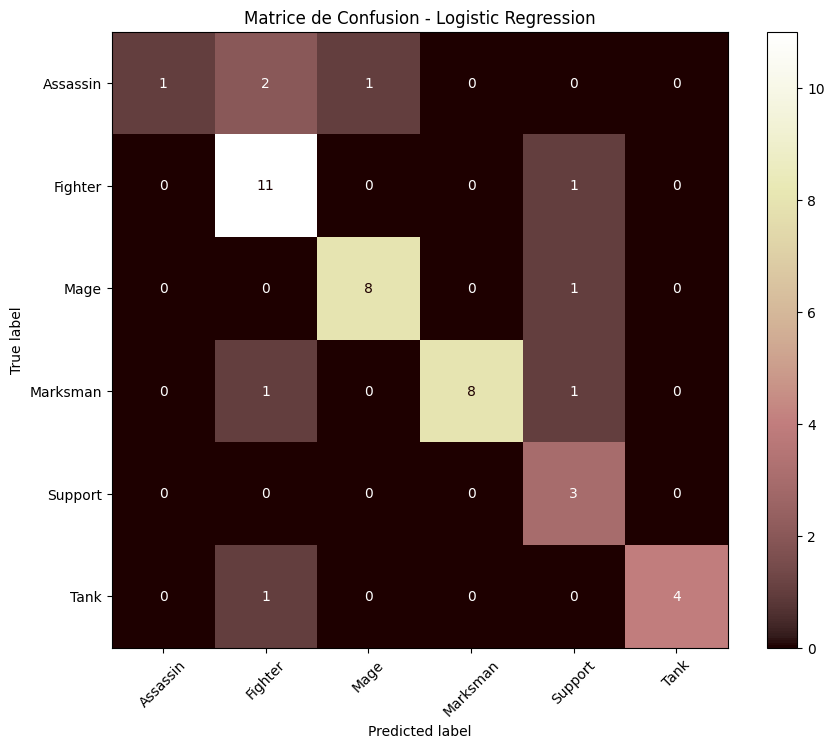

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 1. Pipeline
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))

# 2. Entraînement
print(" Entraînement Logistic Regression...")
pipe_lr.fit(X_tr, y_tr)

# 3. Score & Matrice
score = pipe_lr.score(X_te, y_te)
print(f" Précision : {score:.2%}")

# Affichage graphique
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipe_lr, X_te, y_te, 
    ax=ax, 
    cmap="pink", 
    xticks_rotation=45 
)
plt.title("Matrice de Confusion - Logistic Regression")
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# 1. Pipeline
pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

# 2. Entraînement
print("🤖 Entraînement LDA...")
pipe_lda.fit(X_tr, y_tr)

# 3. Score & Matrice
score = pipe_lda.score(X_te, y_te)
print(f"✅ Précision : {score:.2%}")

# Affichage graphique
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipe_lda, X_te, y_te, 
    ax=ax, 
    cmap="Greens", # Couleur verte pour changer
    xticks_rotation=45
)
plt.title("Matrice de Confusion - LDA")
plt.show()

In [ ]:
from sklearn.svm import LinearSVC


# 1. Pipeline
pipe_svc = make_pipeline(StandardScaler(), LinearSVC(dual="auto", max_iter=5000))

# 2. Entraînement
print("🤖 Entraînement Linear SVC...")
pipe_svc.fit(X_tr, y_tr)

# 3. Score & Matrice
score = pipe_svc.score(X_te, y_te)
print(f"✅ Précision : {score:.2%}")

# Affichage graphique
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipe_svc, X_te, y_te, 
    ax=ax, 
    cmap="Oranges", # Couleur orange
    xticks_rotation=45
)
plt.title("Matrice de Confusion - Linear SVC")
plt.show()

Enrgistremnt du modèle final 

In [12]:
import joblib



#1 : On prend la liste des colonnes
features_cols = [
    col for col in tableau_champ.columns 
    if col not in ["Name", "Class", "Target"]
]

#2 : On prépare les données d'entraînement (converssion aussi en vrai)
X = tableau_champ.select(features_cols)
y = tableau_champ.select("Class")

#3 : On crée et entraîne le Pipeline Final 
modele_final = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))

print("Entraînement final en cours...")
modele_final.fit(X, y)
print("Modèle entraîné !")

#4 : On sauvegarde les paramètres
package = {
    "pipeline": modele_final, 
    "features": features_cols, 
    "description": "Modèle de regression logistique pour prédiction la classe des champions LoL"
}

#5 : Enregistrement sur le disque dur ( god bless)
filename = "lol_champ_model.pkl"
joblib.dump(package, filename)

print(f"Le fichier '{filename}' est prêt.")


Entraînement final en cours...
Modèle entraîné !
Le fichier 'lol_champ_model.pkl' est prêt.
